In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

In [46]:
df = pd.read_excel("amazon.xlsx")

In [47]:
df.head()


,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [48]:
df.info


<bound method DataFrame.info of       Star  HelpFul                                          Title                                             Review
0        5        0                                    looks great                                      Happy with it
1        5        0  Pattern did not align between the two panels.  Good quality material however the panels are m...
2        5        0               Imagery is stretched. Still fun.  Product was fun for bedroom windows.<br />Imag...
3        5        0                 Que se ven elegantes muy finas   Lo unico que me gustaria es que sean un poco ...
4        5        0                             Wow great purchase  Great bang for the buck I can't believe the qu...
...    ...      ...                                            ...                                                ...
5606     4        0                                      Recommend  Great product for reasonable money.  Delivered...
5607     5        0     

In [49]:
df["Review"]=df["Review"].str.lower()
df

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windows.<br />imag...
3,5,0,Que se ven elegantes muy finas,lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,great bang for the buck i can't believe the qu...
...,...,...,...,...
5606,4,0,Recommend,great product for reasonable money. delivered...
5607,5,0,"Terrible , different colors. I returned",color is way off and panels do not match
5608,5,0,Extremely pleasing,these are great for my studio as they compleme...
5609,5,0,Perfect,brought out the beauty in kids room. they love...


In [50]:
df["Review"]=df["Review"].str.replace("[^\w\s]","")


In [51]:
df["Review"]=df["Review"].str.replace("\d","")

stpwords
nltk.download('stopwords')


In [52]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\betul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
sw=stopwords.words("english")
df["Review"]=df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw ))


Rarewords/custom words

In [54]:
sil=pd.Series("".join(df["Review"]).split()).value_counts([-1000])
df["Review"]=df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sil))
df

,Star,HelpFul,Title,Review
0,5,0,looks great,
1,5,0,Pattern did not align between the two panels.,mis-matched.
2,5,0,Imagery is stretched. Still fun.,
3,5,0,Que se ven elegantes muy finas,largas
4,5,0,Wow great purchase,
...,...,...,...,...
5606,4,0,Recommend,recommend.
5607,5,0,"Terrible , different colors. I returned",
5608,5,0,Extremely pleasing,
5609,5,0,Perfect,


Lemmatization

In [55]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\betul\AppData\Roaming\nltk_data...


True

In [56]:
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['Review'].head(10)

0                
1    mis-matched.
2                
3          largas
4                
5                
6                
7                
8                
9                
Name: Review, dtype: object

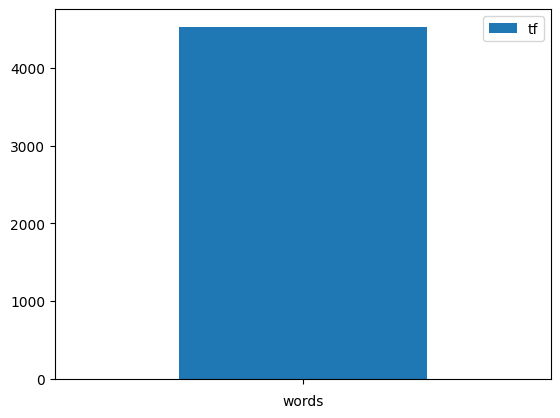

In [60]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()


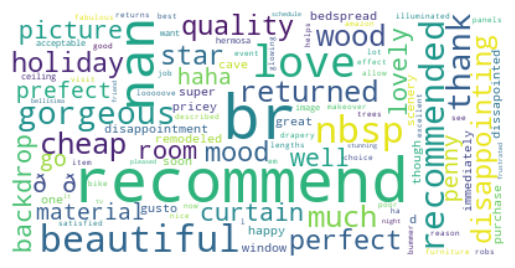

In [61]:
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [63]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\betul\AppData\Roaming\nltk_data...


True

In [64]:
sia = SentimentIntensityAnalyzer()

In [65]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df.groupby("Sentiment_Label")["Star"].mean()


Sentiment_Label
neg   4.40
pos   4.68
Name: Star, dtype: float64

In [66]:
train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["Sentiment_Label"],
                                                    random_state=42)


In [67]:
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)


In [68]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)


In [69]:
y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))

cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()


              precision    recall  f1-score   support

         neg       1.00      0.98      0.99      1395
         pos       0.20      0.88      0.33         8

    accuracy                           0.98      1403
   macro avg       0.60      0.93      0.66      1403
weighted avg       0.99      0.98      0.99      1403



0.9750533807829183

In [70]:
random_review = pd.Series(df["Review"].sample(1).values)
yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(yeni_yorum)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')


Review:   
 Prediction: ['neg']


In [71]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()


0.9814667005592271